In [1]:
#Import packages used
import pandas as pd
import os as os
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV,ElasticNetCV
import copy

(1460, 80)

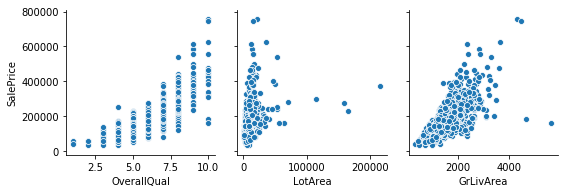

In [2]:
#Connect to data, note this is the training dataset, test/holdout dataset is is another csv
data_path = r"C:\Users\Tom-T\Google Drive\Queen's MMA\Predictive Modelling - MMA 867\Assignment 1\House Prices Kaggle\train.csv"
data = pd.read_csv(data_path,index_col='Id')
data.head()


#EDA - a lot of guidance from the competition creator's notes found here: http://jse.amstat.org/v19n3/decock.pdf
#Note, this pdf is referenced heavily in this analysis
pp = sns.pairplot(data=data,
                  y_vars=['SalePrice'],
                  x_vars=['OverallQual', 'LotArea','GrLivArea'])

#From the plots of some features and sale price, we can see that there are some exceptional sales of large houses for too high or low price
#It also looks like the variability of the sale price increases with the size of the living area - this is noted and we will
#log transform these two variables in the model

#Size of the dataset
data.shape


In [3]:
#Load testing dataset 
data_path = r"C:\Users\Tom-T\Google Drive\Queen's MMA\Predictive Modelling - MMA 867\Assignment 1\House Prices Kaggle\test.csv"
data = pd.read_csv(data_path,index_col='Id')
data.shape

(1459, 79)

In [1]:
# #Connect to holdout dataset to leverage preprocessing code, remember we are using the name "data" for both datasets to
# #leverage the same cleansing code, so will have to comment each line and run as appropriate
# #data_train = copy.deepcopy(data)
# data_test = copy.deepcopy(data)


# train_objs_num = len(data_train)
# data = pd.concat(objs=[data_train, data_test], axis=0)
# data.loc[:, "SalePrice"] = data.loc[:, "SalePrice"].fillna(1)
# dataset_preprocessed = pd.get_dummies(data,drop_first = True)

# dataset_preprocessed['SalePrice'] = np.log(dataset_preprocessed['SalePrice'])
# dataset_preprocessed['GrLivArea'] = np.log(dataset_preprocessed['GrLivArea'])

# train_preprocessed = dataset_preprocessed[:train_objs_num]
# test_preprocessed = dataset_preprocessed[train_objs_num:]

# data_submission_test = copy.deepcopy(test_preprocessed)
# data = copy.deepcopy(train_preprocessed)

In [3]:
nullcheck = data.isnull().sum()
nullcheck[nullcheck > 0]


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
#Data Preprocessing; many of the ideas are taken from either the author's document, or inspired from this notebook:
#https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

#As recommended by the creator, let's remove all houses with a living area greater than 4,000 square feet..(don't do this for submission dataset!)
data = data.drop(data[data.GrLivArea > 4000].index)

#Check for missing data - the pdf and data dictionary indicates that the dataset is clean, which means null values likely mean a value of 0 or none
#For example, null values in LotFrontage and Alley mean there is no lot frontage (feet) or Alleyway access to the house (yes/no)
nullcheck = data.isnull().sum()
nullcheck[nullcheck > 0]

#Replacing nulls with 0 or "NA" string values depending on column datatype;
data.loc[:, "Alley"] = data.loc[:, "Alley"].fillna("NA")
data.loc[:, "BsmtQual"] = data.loc[:, "BsmtQual"].fillna("NA")
data.loc[:, "BsmtCond"] = data.loc[:, "BsmtCond"].fillna("NA")
data.loc[:, "BsmtExposure"] = data.loc[:, "BsmtExposure"].fillna("NA")
data.loc[:, "BsmtFinType1"] = data.loc[:, "BsmtFinType1"].fillna("NA")
data.loc[:, "BsmtFinType2"] = data.loc[:, "BsmtFinType2"].fillna("NA")
data.loc[:, "Fence"] = data.loc[:, "Fence"].fillna("NA")
data.loc[:, "FireplaceQu"] = data.loc[:, "FireplaceQu"].fillna("NA")
data.loc[:, "GarageType"] = data.loc[:, "GarageType"].fillna("NA")
data.loc[:, "GarageFinish"] = data.loc[:, "GarageFinish"].fillna("NA")
data.loc[:, "GarageQual"] = data.loc[:, "GarageQual"].fillna("NA")
data.loc[:, "GarageCond"] = data.loc[:, "GarageCond"].fillna("NA")
data.loc[:, "LotFrontage"] = data.loc[:, "LotFrontage"].fillna(0)
data.loc[:, "MiscFeature"] = data.loc[:, "MiscFeature"].fillna("NA")
data.loc[:, "PoolQC"] = data.loc[:, "PoolQC"].fillna("NA")
data.loc[:, "MasVnrArea"] = data.loc[:, "MasVnrArea"].fillna(0)
data.loc[:, "MasVnrType"] = data.loc[:, "MasVnrType"].fillna("None")
data.loc[:, "BsmtFinSF1"] = data.loc[:, "BsmtFinSF1"].fillna("NA")
data.loc[:, "BsmtFinSF2"] = data.loc[:, "BsmtFinSF2"].fillna("NA")
data.loc[:, "BsmtUnfSF"] = data.loc[:, "BsmtUnfSF"].fillna(0)
data.loc[:, "BsmtFullBath"] = data.loc[:, "BsmtFullBath"].fillna(0)
data.loc[:, "BsmtHalfBath"] = data.loc[:, "BsmtHalfBath"].fillna(0)
data.loc[:, "TotalBsmtSF"] = data.loc[:, "TotalBsmtSF"].fillna(0)    
data.loc[:, "GarageCars"] = data.loc[:, "GarageCars"].fillna(0)
data.loc[:, "GarageArea"] = data.loc[:, "GarageArea"].fillna(0)



#Problem variable: Garage Year Built (GarageYrBlt) has 81 NA values. Since we need this numeric field to have no nulls in 
#order to build our interaction terms, we must address this. I have decided to use the median in this case after some research
data.loc[:, "GarageYrBlt"] = data.loc[:, "GarageYrBlt"].fillna(data.GarageYrBlt.median())
data.loc[:, "BsmtUnfSF"] = data.loc[:, "BsmtUnfSF"].fillna(data.BsmtUnfSF.median())


#Additionally, the MSSubClass columns is actually caegorical, and the month sold column should not be numeric
data = data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

#Inspired from the kaggle notebook, I realized it is potentially advantageous to change categorical variables to ordinal.
#For example, houses with pools are usually worth (and sold for) more, and all variables involving the quality of the house should affect price similarly.

data = data.replace({"Alley" : {"NA" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"NA" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                     #Interpreted Fence quality based on "Good" vs "Minimum" values 
                       "Fence" : {"NA": 0, "MnWw" : 1, "MnPrv" : 1, "GdWo" : 2, "GdPrv" : 2},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     #Severely sloped land is negatively associated with house value
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )



In [7]:
#Additional Preprocessing/Cleansing for holdout dataset, luckily, only a tiny amount of records have nulls, as most of the
#data was preprocessed well beforehand (about 1-2 records per attribute, and many are on the same record)

#imputing mode values for categorical NA variables that cannot contain an NA value based on the neighborhood of the house
data["MSZoning"]= data.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.mode()[0])
data[data["MSZoning"].isnull()]

data["Utilities"]= data.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.mode()[0])
data[data["Utilities"].isnull()]

data["Exterior1st"]= data.groupby('Neighborhood')['Exterior1st'].transform(lambda x: x.mode()[0])
data[data["Exterior1st"].isnull()]

data["Exterior2nd"]= data.groupby('Neighborhood')['Exterior2nd'].transform(lambda x: x.mode()[0])
data[data["Exterior2nd"].isnull()]

data["KitchenQual"]= data.groupby('Neighborhood')['KitchenQual'].transform(lambda x: x.mode()[0])
data[data["KitchenQual"].isnull()]

data["Functional"]= data.groupby('Neighborhood')['Functional'].transform(lambda x: x.mode()[0])
data[data["Functional"].isnull()]

data["SaleType"]= data.groupby('Neighborhood')['SaleType'].transform(lambda x: x.mode()[0])
data[data["SaleType"].isnull()]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,


In [9]:
#Now our base dataset has been pre-processed let's engineer features and encode dummy variables

#One hot encoding for remaining categorical variables
data = pd.get_dummies(data,drop_first = True)

# interaction terms of all independent variables...remember to execute this step for the data_submission_test data as well!
interaction_only = PolynomialFeatures(2, interaction_only=True) 

interaction_only.fit_transform(data)
data.head()
data.shape


(1458, 1035)

In [39]:
#Creating the scoring methods

#Root mean squared error using cross validation
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def compute_rmse_cv(model,X,y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 10))
    return(rmse.mean())


#mean_squared_error(y_true,y_pred)

#MAPE
def compute_mape_score(y_test_input, y_pred_input):
    y_test_input = np.array(y_test_input).reshape(-1,)
    y_pred_input = np.array(y_pred_input).reshape(-1,)
    percent_errors = np.abs((y_test_input - y_pred_input) / y_test_input) * 100
    return np.mean(np.array(percent_errors))

SCORING_CONFIG = {'mape' : compute_mape_score}


In [50]:
#Let's begin modelling

#Test train split
X = data.loc[:, data.columns != 'SalePrice']
y = data.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Simple OLS
OLS = LinearRegression().fit(X_train, y_train)

y_pred = OLS.predict(X_test)
pred_prices = np.exp(y_pred)
test_prices = np.exp(y_test)

#compute_mape_score(test_prices,pred_prices)

compute_rmse_cv(OLS,X_test,y_test)

#Around 14-19% error 

In [51]:
#Lasso L1 Regularization, with 10-fold cross validation
# Set of values to check from:
ALPHAS = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 250.0, 500.0]

#Build the Lasso CV model
lasso_cv = LassoCV(alphas=ALPHAS, max_iter=1e7, tol=1e-2, cv=10)
lasso_cv.fit(np.array(X_train), np.array(y_train).reshape(-1,))

compute_rmse_cv(lasso_cv,X_test,y_test)

#Much better! Around 12% on test data

0.11514008122380084

In [9]:
#Ridge L2 Regularization, with 10-fold cross validation
ALPHAS = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 250.0, 500.0]

ridge_cv = RidgeCV(alphas=ALPHAS, cv=10)
ridge_cv.fit(X_train, y_train)

#check the error
compute_rmse_cv(ridge_cv,X_test,y_test)

#Slightly better performance it seems (although it may be based on the number of cross validations)

0.12661680850675291

In [56]:
#ElasticNet mixed L1 and L2 Regularization, with 10-fold cross validation
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas=ALPHAS, 
                          max_iter = 1e7, cv = 10)

elasticNet.fit(X_train, y_train)

#check error
compute_rmse_cv(elasticNet,X_test,y_test)

#ElasticNet actually seems to perform worse than Ridge, I'm guessing this is because

0.12522144899290066

In [72]:
#Checking error after inverse log our transformed variable
y_pred = lasso_cv.predict(X_test)
pred_prices = np.exp(y_pred)
test_prices = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(test_prices,pred_prices))
print(rmse_1)

20164.2422623756

In [60]:
#here we go back and execute all of the preprocessing code for the training dataset (to leverage the same code, the 
#holdout dataset will also enter a dataframe called "data")

holdout_X = data_submission_test.loc[:, data.columns != 'SalePrice']

y_pred_holdout = lasso_cv.predict(holdout_X)
y_pred_SalePrice = np.exp(y_pred_holdout)

y_pred_SalePrice[:1000]

Submission = pd.DataFrame(y_pred_SalePrice)
Submission.to_csv(r"C:\Users\Tom-T\Google Drive\Queen's MMA\Predictive Modelling - MMA 867\Assignment 1\House Prices Kaggle\Tom_Submission.csv")
